<a href="https://colab.research.google.com/github/simonetome/ApplieAI-Biomedicine-Masciulli-Pietrobon-Tome/blob/main/ParsingVisualizationFiltering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Final assignment description </h1>

The objective is to classify three different classes of ECG signals.
-<h3> Normal sinus rythm; </h3> <br> 
![Normal sinus rythm](img/normal.PNG)
-<h3> Premature ventricular complex (PVC); </h3> <br>
![PAC](img/pvc.PNG)
-<h3> Premature atrial complex (PAC); </h3> <br>
![PVC](img/pac.PNG)


We must classify each beat of the signal and each beat of the training set is labelled with:
- N: normal sinus rythm; <br>
- S: supraventricular beats (PAC); <br>
- V: ventricular beats (PVC); <br>

<h2>Dataset </h2>

- 105 patients;
- fs: 128 or 250 Hz;
- 2 leads ECG -> 2 ecg signal for each patient; 
- Rpeaks are annotated in the dedicated .mat file;

File format: 
- [PatientID]\_[fs]+".mat" $\rightarrow$ 2 leads ECG signal;
- [PatientID]\_[fs]+\_[ann]+".mat" $\rightarrow$ labelling of the Rpeaks;
- [PatientID]\_[fs]+\_[rpk]+".mat" $\rightarrow$ Rpeaks location in the signal (at which time an Rpeak appears);



In [ ]:
!pip install heartpy

In [1]:
import os
import tensorflow as tf
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

import pandas as pd
from scipy.signal import butter, lfilter
import heartpy as hp

from keras.preprocessing.sequence import pad_sequences
import math

import zipfile  
import io
from PIL import Image

In [ ]:
#Test if GPU is available for tensorflow
tf.config.list_physical_devices('GPU')

[]

In [ ]:
#IF local runtime used -> Set os.cwd as google drive volume , mounted locally
os.chdir('G:\Il mio Drive')
cwd = os.getcwd()
cwd = os.path.join(cwd,'Colab2022/AppliedAI/FinalAssignment')
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

FileNotFoundError: ignored

In [2]:
#IF Colab cloud GPU used -> Mount the My Drive folder and set cwd
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/FinalAssignment'
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

Mounted at /content/drive


In [ ]:
#IF jupyter is used locally
dataset_current_folder = "training_set.zip" # where the zip is
dataset_folder = "C://Users//simon//Desktop//AppliedAI-project" # where I want the dataset - avoid the current folder as Git doesn't allow huge uploads

with zipfile.ZipFile(dataset_current_folder, 'r') as zip: # extract the zip file into the desired folder 
    zip.extractall(dataset_folder)

In [3]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
  label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
  peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
  signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
  if os.path.isfile(label_filepath):
    mat_file = loadmat(label_filepath)
    label = np.asarray(mat_file['labels'])
  if os.path.isfile(peak_filepath):
    mat_file = loadmat(peak_filepath)
    peak = np.asarray(mat_file['rpeaks'])
  if os.path.isfile(signal_filepath):
    mat_file = loadmat(signal_filepath)
    signal = np.asarray(mat_file['ecg'] )

  return label, peak, signal


labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))

<h2>Data visualization</h2>

In [23]:
def set_ax_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [24]:

def plot_signal(sigID,length,signals=ecg_signals, lead=0, timeDomain=False,w_size=12, h_size=3):
    """
      Method that plots an ECG signal for a given number of samples.
        :param int sigID: the index of the signal
        :param int length: the number of samples to be plotted
        :param signals: the ecg_signals list
        :param int lead: the lead to be plotted
        :param boolean timeDomain: True to use seconds as unit of the x-axis
    """

    signal = signals[sigID]
    fs = frequencies[sigID]
    
    if timeDomain:
      x = np.arange(0, signal.shape[0]/fs, 1/fs) 
      x = x[:length]
    else:
      x = np.arange(length)

    y = signal[:length,lead]
    fig, ax = plt.subplots()
    set_ax_size(w_size,h_size)
    ax.plot(x, y, linewidth=2.0)

    # we are plotting only the defined samples, so we must count how many peaks 
    peak_counter = 0
    
    for peak in rpeaks[sigID][:,0]:
        if (peak > length):
            break
        peak_counter += 1
    
    x = rpeaks[sigID][:peak_counter,0]  # samples of the peaks in between the defined length 
    y = signals[sigID][x,lead] # amplitude value of the peaks 
    
    if timeDomain:
      ax.scatter(x/fs,y,color = "red")
    else:
      ax.scatter(x,y,color = "red")
    peaks_labels = labels[sigID][:peak_counter]
    if timeDomain: 
      offset = .2
      for i,label in enumerate(peaks_labels):
        ax.annotate(label,(x[i]/fs-offset,y[i]),fontsize = "large")
    else:
      offset = 20
      for i,label in enumerate(peaks_labels):
        ax.annotate(label,(x[i]-offset,y[i]),fontsize = "large")

    
    plt.show()
    

def plot_comparison(raw_signal, filtered_signal, sigID, length, peaks=rpeaks, labels=labels, lead=0, title = "", w_size=12, h_size=3):
  """
    Method that plots on the same graph both raw and filtered ECG signal for a given number of samples.
      :param raw_signal: the raw ECG signal
      :param filtered_signal: the same ECG signal after manipulation
      :param int sigID: the index of the signal
      :param int length: the number of samples to be plotted
      :param peaks: the rpeaks list
      :param labels: the rpeaks labels list
      :param int lead: the lead to be plotted
      :param string title: optional title of the plot
  """
  peaks_temp = peaks[sigID]
  plotted_samples  = length
  fig, ax = plt.subplots()
  set_ax_size(w_size,h_size)
  ax.plot(raw_signal[:plotted_samples,lead])
  ax.plot(filtered_signal[:plotted_samples,lead])

  ax.set_title(title)
  peak_counter=0
  for peak_sample in peaks_temp:
    if peak_sample > plotted_samples:
      break
    peak_counter +=1
    ax.plot(peak_sample, raw_signal[peak_sample,lead] , marker="o", color="red", alpha=.5)
    ax.plot(peak_sample, filtered_signal[peak_sample,lead] , marker="+", color="blue", alpha=.5)


  offset = 20
  peaks_labels = labels[sigID][:peak_counter]
  for i,label in enumerate(peaks_labels):
    ax.annotate(label,(peaks_temp[i]-offset,raw_signal[peaks_temp[i],lead]),fontsize = "large")

  plt.show()

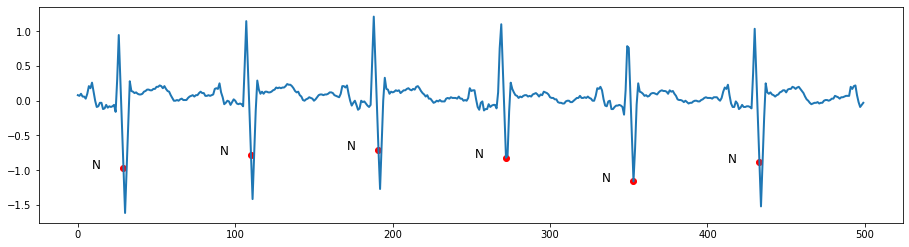

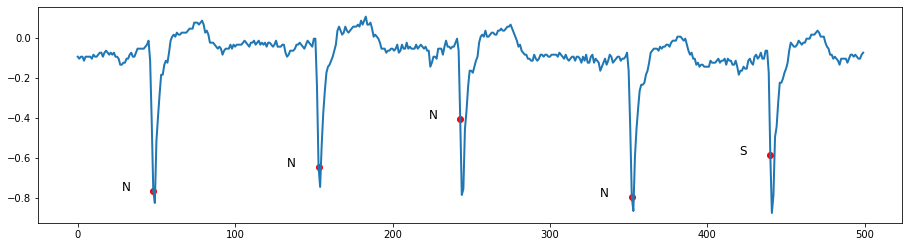

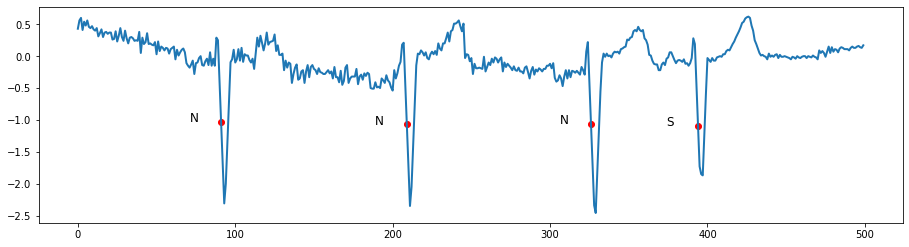

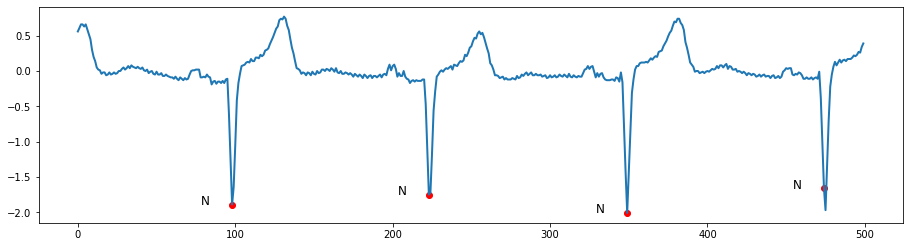

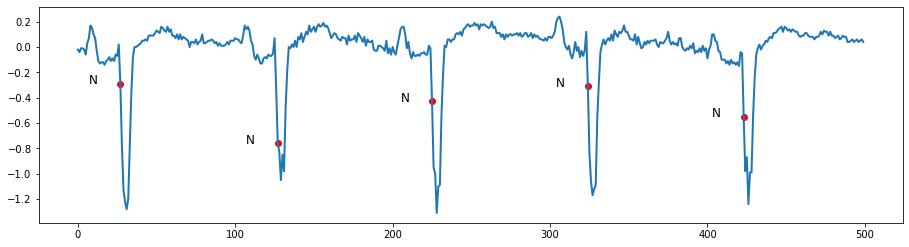

In [22]:
# plot first 5 signals 
for i in range(5):
    plot_signal(i,500, lead=1)


In [ ]:
##Da fixare, non gira su colab

# this function creates a patch for the defined signal & peak and save it in the "dataset_folder/Patches" folder 
# under the name of [SIGNAL_ID]_[peakID]_[LABEL].png
def create_patch(sigID,peakID):
    
    signal = ecg_signals[sigID]

    prev = rpeaks[sigID][peakID-1]
    peak = rpeaks[sigID][peakID]
    succ = rpeaks[sigID][peakID+1] 
    x = np.arange(int((peak+prev)/2),int((peak+succ)/2)) # lowest x is equal to the average between the peakID and the previous, dual for the highest x 
    y = signal[x,0]
    fig, ax = plt.subplots()
    ax.plot(x, y, linewidth=2.0)
    
    plt.axis('off')         # axes are useless in input to the model 
    plt.savefig(dataset_folder+"/Patches/"+str(ids[sigID])+"_"+str(peakID)+"_"+labels[sigID][peakID]+".png",format="png",facecolor = "white",bbox_inches='tight',pad_inches = 0) # save the image 
   

In [ ]:
create_patch(4,7) # patch for the 4th signal, 7th peak (has to be cut properly)

Text(0.5, 1.0, 'Signal length distribution')

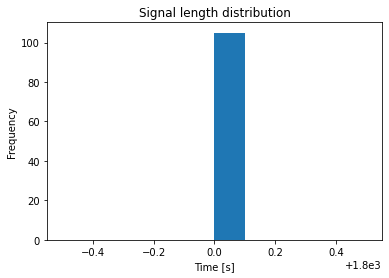

In [ ]:
#Compute the duration in seconds of each signal
#Iterate through the different signals: store signal length and divide by sampling frequenzy to obtain it in senconds.
length_recordings = list()
for i, signal in enumerate(ecg_signals):
  length_recordings.append(len(signal[:])/frequencies[i])


# Transform to pandas series and plot histogram.
length_rec_s = pd.Series(length_recordings)
ax = length_rec_s.plot.hist(bins= 10)
ax.set_xlabel("Time [s]")
ax.set_title("Signal length distribution")

Each ecg has a total duration of 1800 seconds, both the ones at 180 and 250 Hz. The latter have a greater number of samples.

#Apply a bandpass filter
...
#Use heartpy lib methods
...

# Filter using Convolution
Another way to low-pass a signal is to use convolution. In this method you create a window (typically a bell-shaped curve) and convolve the window with the signal. The wider the window is the smoother the output signal will be. Also, the window must be normalized so its sum is 1 to preserve the amplitude of the input signal.

In [140]:
#Preprocessing used in practical lessons
def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """

        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y

def signal_preprocessing(data, max_length, lowcut= 1, highcut = 47, signal_freq = 500, filter_order = 3, remove_baseline_wander=False, apply_convolution = False): 
        """
        Method that applies a bandpass filter and use padding to make all the samples of equal length
        :param data: an ECG signal
        :param int max_length: the maximum length to which the sample will be padded
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :param boolean remove_baseline_wander: if True, apply heartpy remove_baseline_wander to the signal
        :param boolean apply_convolution: if True, apply convolution to improve signal smoothness
        :return array: filtered and padded data
        """
        #Potrebbe essere dopo aver applicato il filtro?
        if remove_baseline_wander:
          filtered_ecg=data.copy()
          filtered_ecg[:,0] = hp.remove_baseline_wander(data[:,0], signal_freq)
          filtered_ecg[:,1] = hp.remove_baseline_wander(data[:,1], signal_freq)
          data=filtered_ecg
        

        filtered_ecg = bandpass_filter(data, lowcut, highcut, signal_freq, filter_order)

        if apply_convolution:
          # https://swharden.com/blog/2020-09-23-signal-filtering-in-python/
          # create a normalized Hanning window
          windowSize = 5
          window = np.hanning(windowSize)
          window = window / window.sum()
          filtered_ecg[:,0] = np.convolve(window, filtered_ecg[:,0], mode='same')
          filtered_ecg[:,1] = np.convolve(window, filtered_ecg[:,1], mode='same')

        #Note that the padding may be changed, depending on the model input
        filtered_ecg = np.moveaxis(filtered_ecg, -1, 0)
        X = pad_sequences(filtered_ecg, maxlen=max_length, dtype='float32', truncating='post',padding="post")

        X = np.moveaxis(X, -1, 0) #in order to adapt the signal to the input of the network
        #Queste ultime due righe sono da controllare
        return X

In [151]:
#Compute max_length to apply padding and make all the signals of the same number of samples (they've all the same sampling time of 1800sec)
#If signals will be cropped, must be padded to multiple of the crop size
max_length  = 0
for signal in ecg_signals:
  if signal.shape[0] > max_length:
    max_length = signal.shape[0]


signals_filt = np.empty((len(ecg_signals),max_length,2))

for i, signal in enumerate (ecg_signals):
  if frequencies[i]==250:
    lowcut = 2#2
    highcut = 94 #47
  else:
    lowcut = 4#4 #0.256
    highcut = 47#30 #12.032
  filtered = signal_preprocessing(signal, max_length= max_length, signal_freq = frequencies[i], lowcut= lowcut, highcut = highcut, filter_order=3, remove_baseline_wander=True, apply_convolution=True)
  signals_filt[i]= filtered



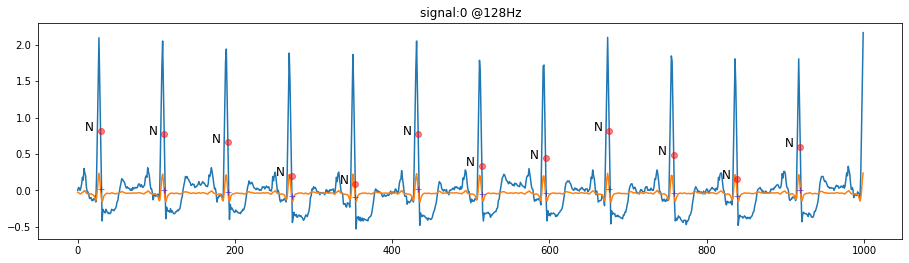

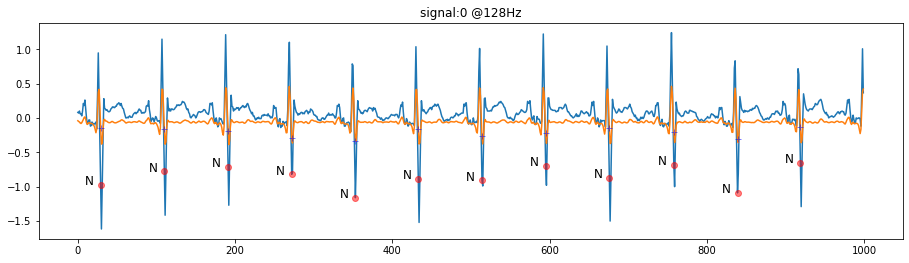

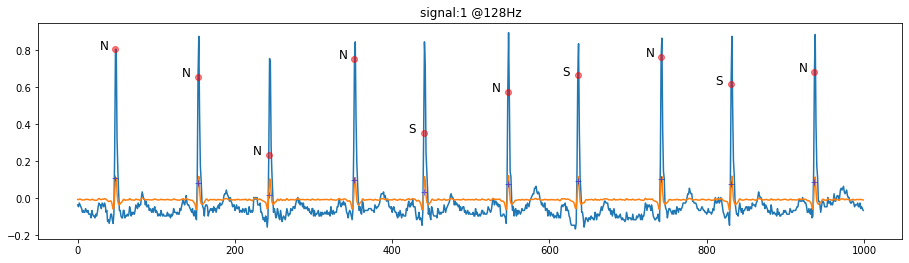

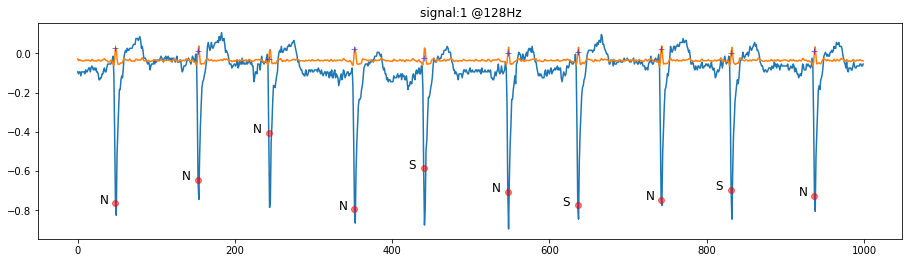

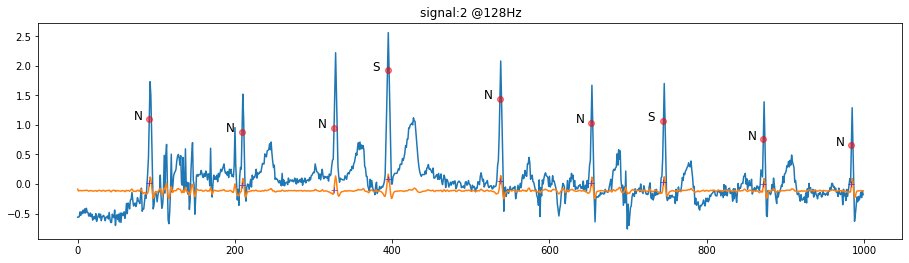

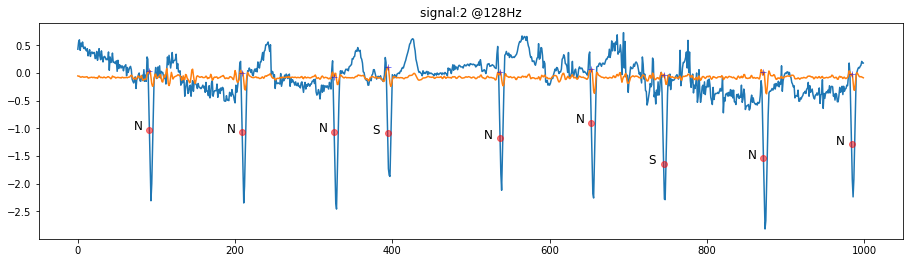

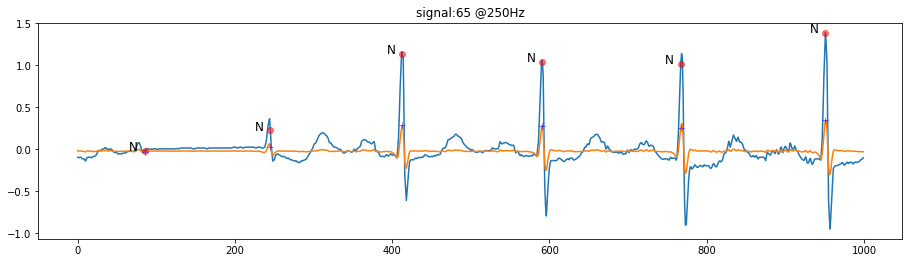

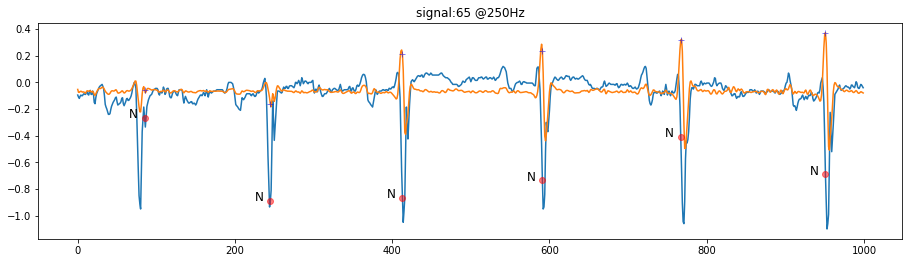

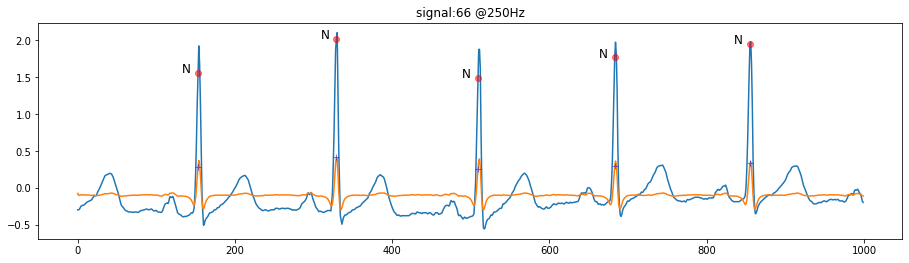

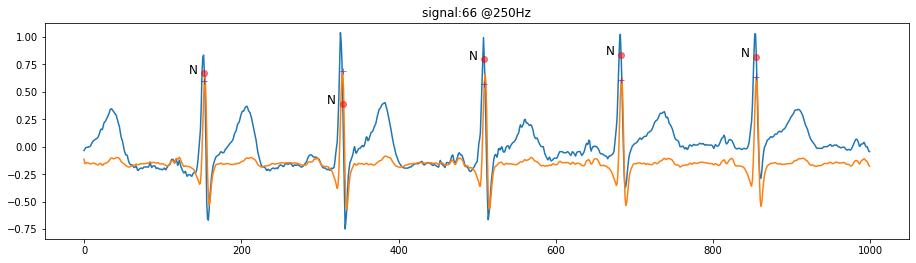

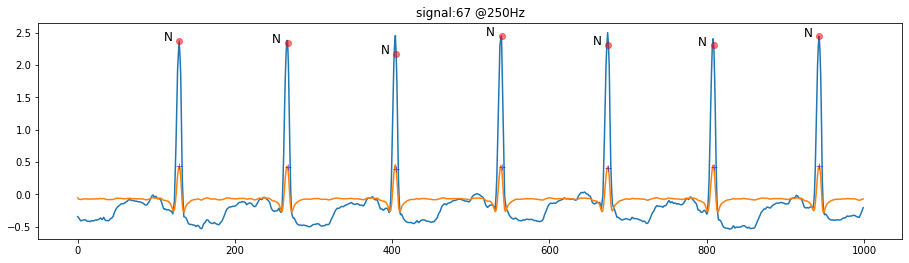

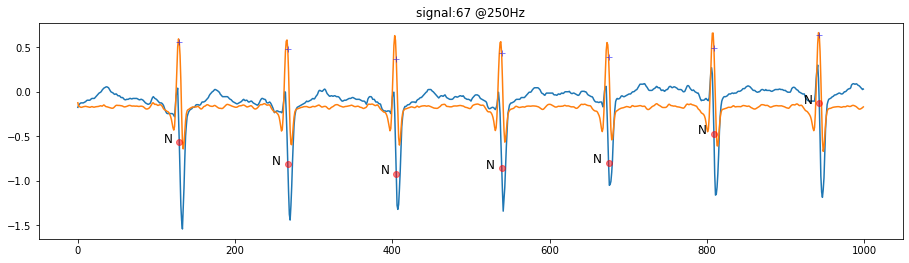

In [152]:
plot_count_250 = 0
plot_count_128 = 0
for i, signal in enumerate(ecg_signals):
  if (plot_count_250 < 3 and frequencies[i]==250) or (plot_count_128 <3 and frequencies[i]==128):
    plot_comparison(signal,signals_filt[i], i, 1000, lead=0, title="signal:"+str(i)+" @"+str(frequencies[i])+"Hz")
    plot_comparison(signal,signals_filt[i], i, 1000, lead=1, title="signal:"+str(i)+" @"+str(frequencies[i])+"Hz")
    if frequencies[i]==250:
      plot_count_250 += 1
    elif  frequencies[i]==128:
      plot_count_128 += 1


In [148]:
#to be fixed, do not use
#potrebbe essere utlie normalizzare prima del preprocessing
sig_mean = np.nanmean(signals_filt, axis=1).mean(axis=0)
sig_std = np.nanstd(signals_filt, axis=1).mean(axis=0)
signals_filt = (signals_filt - sig_mean)/ sig_std
print(sig_mean)
print(sig_std)


[-0.00507904 -0.01018135]
[0.04665994 0.08077903]


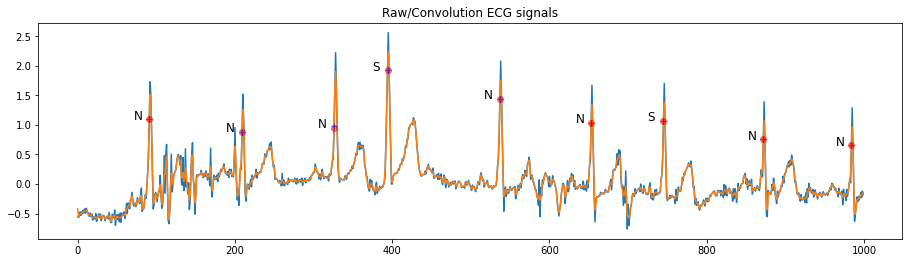

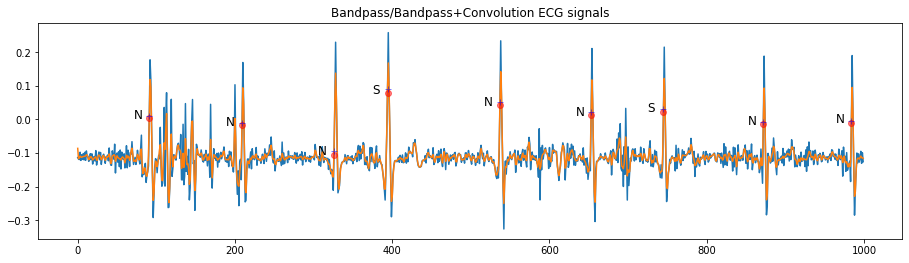

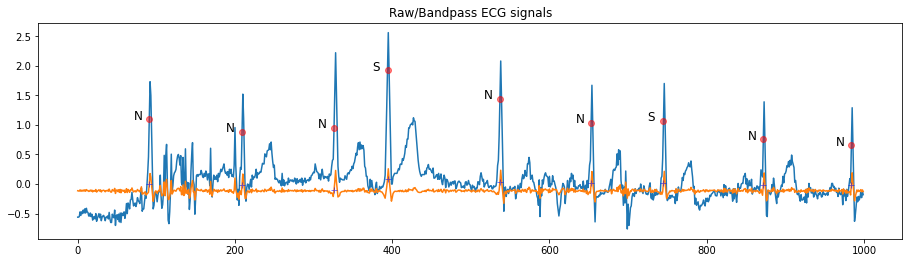

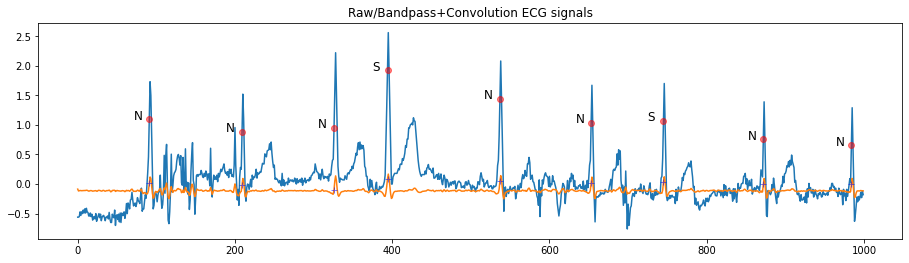

In [129]:
# Filter using Convolution
# https://swharden.com/blog/2020-09-23-signal-filtering-in-python/
# create a normalized Hanning window
windowSize = 5
window = np.hanning(windowSize)
window = window / window.sum()
sigID=2
filtered = ecg_signals[sigID].copy()
# filter the data using convolution
filtered[:,0] = np.convolve(window, ecg_signals[sigID][:,0], mode='same')
filtered[:,1] = np.convolve(window, ecg_signals[sigID][:,1], mode='same')
plot_comparison(ecg_signals[sigID],filtered, sigID, 1000, title="Raw/Convolution ECG signals")



#try to do convolution on filtered signal
filtered = signals_filt[sigID].copy()
# filter the data using convolution
filtered[:,0] = np.convolve(window, signals_filt[sigID][:,0], mode='same')
filtered[:,1] = np.convolve(window, signals_filt[sigID][:,1], mode='same')

plot_comparison(signals_filt[sigID],filtered, sigID, 1000, title="Bandpass/Bandpass+Convolution ECG signals")
plot_comparison(ecg_signals[sigID],signals_filt[sigID], sigID, 1000, title="Raw/Bandpass ECG signals")
plot_comparison(ecg_signals[sigID],filtered, sigID, 1000, title="Raw/Bandpass+Convolution ECG signals")

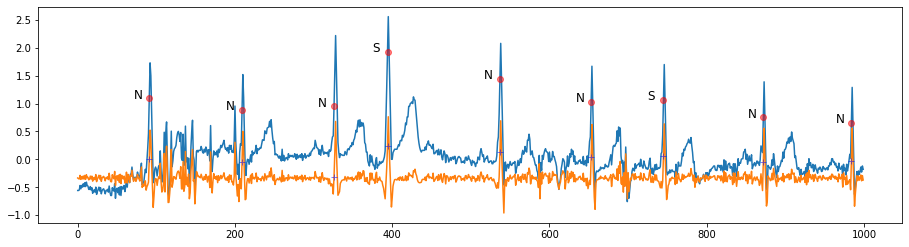

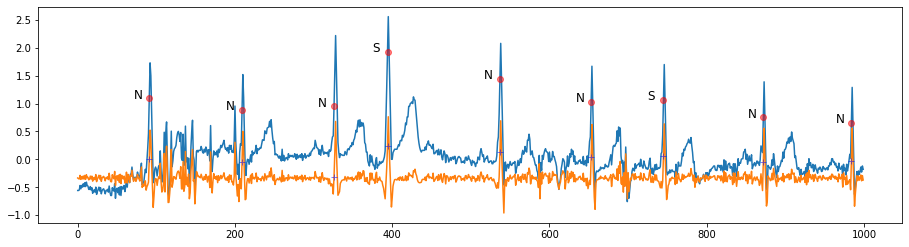

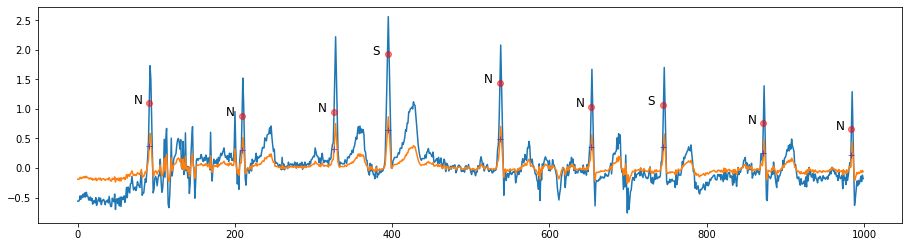

In [123]:
#heartpy lib

filtered=ecg_signals[2].copy()


#temp = np.array(hp.enhance_ecg_peaks(hp.scale_data(ecg_signals[2][:,0]), frequencies[2], 
#                                aggregation='median', iterations=5)) 


filtered[:,0] = hp.remove_baseline_wander(ecg_signals[2][:,0], frequencies[2])
filtered[:,1] = hp.remove_baseline_wander(ecg_signals[2][:,1], frequencies[2])


#temp = np.array(hp.enhance_ecg_peaks(hp.scale_data(filtered[:,0]), frequencies[2], 
#                                aggregation='median', iterations=5))

#temp.resize(filtered[:,0].shape)
#filtered[:,0] = temp
plot_comparison(ecg_signals[2], filtered, 2, 1000)

#filtered = signal_preprocessing(filtered, max_length= max_length, signal_freq = frequencies[i], lowcut= lowcut, highcut = highcut, filter_order=3)



#filtered[:,0] = temp
plot_comparison(ecg_signals[2], filtered, 2, 1000)
plot_comparison(ecg_signals[2], signals_filt[2], 2, 1000)

Apply a bandpass filter and a notch filter to smooth the signal

In [ ]:
# https://towardsdatascience.com/getting-the-right-beat-e18acd48b8c1

from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
import matplotlib.pyplot as plt
def bandpass_filter(data, lowcut, highcut, signal_freq, filter_order):
        """
        Method responsible for creating and applying Butterworth filter.
        :param deque data: raw data
        :param float lowcut: filter lowcut frequency value
        :param float highcut: filter highcut frequency value
        :param int signal_freq: signal frequency in samples per second (Hz)
        :param int filter_order: filter order
        :return array: filtered data
        """

        nyquist_freq = 0.5 * signal_freq
        low = lowcut / nyquist_freq
        high = highcut / nyquist_freq
        b, a = butter(filter_order, [low, high], btype="band")
        y = lfilter(b, a, data)
        return y
def notch_filter(fs, cutoff = 60, q = 30):
    nyq = 0.5*fs
    freq = cutoff/nyq
    b, a = iirnotch(freq, q)
    return b, a


def final_filter(data, fs, order=5, cutoff_low = 1, cutoff_high = 47):
    x = bandpass_filter(data, cutoff_low, cutoff_high, fs, order)
    f, e = notch_filter(fs)
    y = lfilter(f, e, x)     
    return y

In [ ]:
filtered_signals = list()
for i, signal in enumerate(ecg_signals):
  filtered_signals.append(final_filter(signal, frequencies[i]))


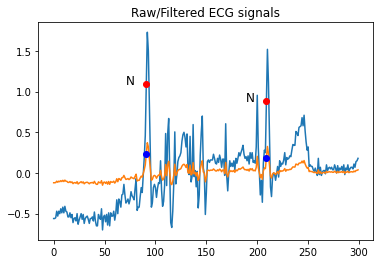

In [ ]:
plot_comparison(ecg_signals[2],filtered_signals[2], 2, 300)